In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def use_gpu():
    torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() 
                                                         else torch.FloatTensor)
use_gpu()

In [3]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-06-30 21:17:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   126MB/s    in 0.5s    

2020-06-30 21:17:41 (126 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('tmp')
zip_ref.close()

In [5]:
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [6]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.826.jpg', 'cat.43.jpg', 'cat.199.jpg', 'cat.967.jpg', 'cat.16.jpg', 'cat.570.jpg', 'cat.234.jpg', 'cat.508.jpg', 'cat.674.jpg', 'cat.515.jpg']
['dog.276.jpg', 'dog.120.jpg', 'dog.677.jpg', 'dog.186.jpg', 'dog.436.jpg', 'dog.738.jpg', 'dog.595.jpg', 'dog.809.jpg', 'dog.828.jpg', 'dog.137.jpg']


In [7]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [8]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

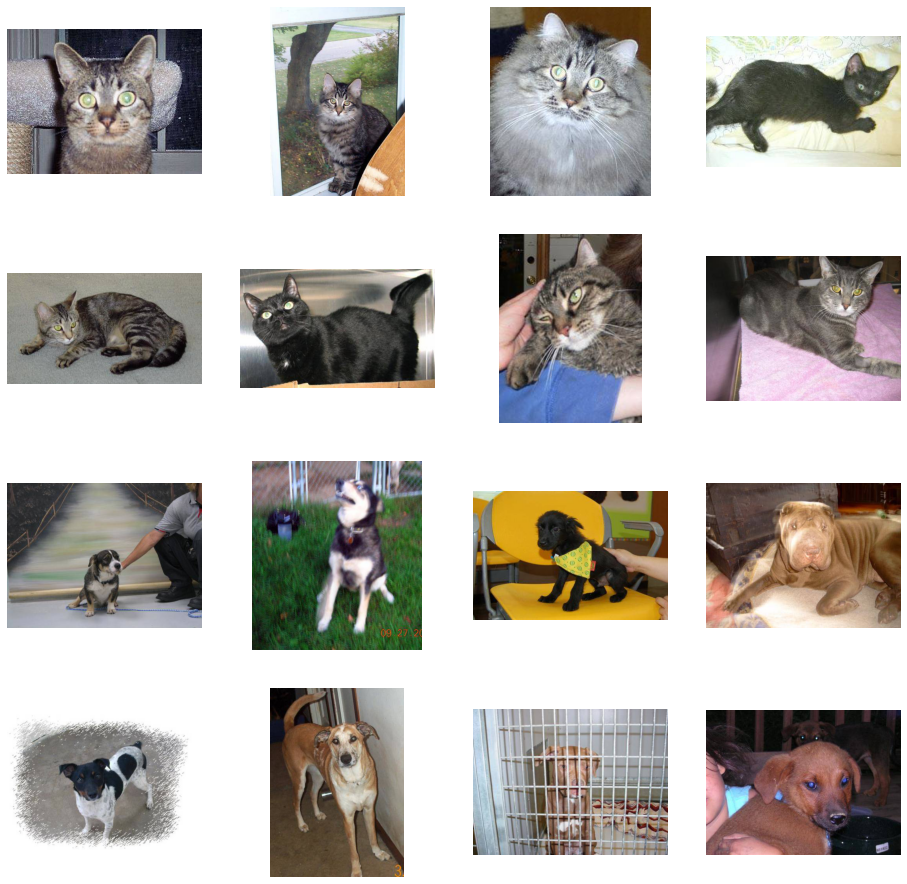

In [9]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [10]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {}, Loss: {:.3f}'.format(epoch, loss.item()))


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, pred = output.max(1)
            test_loss += criterion(output, target).item() 
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader.dataset)

    print('Average loss: {:.3f}, Test Acc: {:.3f} ({}/{})'.format(test_loss, 100.*correct/total, correct, total))


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(2, 2))
        self.fc1 = nn.Linear(in_features=36*36*32, out_features=300)
        self.fc2 = nn.Linear(in_features=300, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=2)
        self.flatten = nn.Flatten()
        
        
    def forward(self, X):
        if torch.cuda.is_available():
            X = X.to(device="cuda")
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)

        X = self.flatten(X)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return X

In [12]:
batch_size = 100
test_batch_size = 50
epochs = 15
lr = 1e-3
criterion = nn.CrossEntropyLoss()

In [13]:
trainset = datasets.ImageFolder(train_dir,transform=transforms.Compose([transforms.Resize(256),
transforms.RandomCrop(150),transforms.ToTensor()]))
testset = datasets.ImageFolder(validation_dir, transform=transforms.Compose([transforms.Resize(256),
transforms.RandomCrop(150),transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset,batch_size=test_batch_size, shuffle=False)

In [14]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Train Epoch: 1, Loss: 0.718
Average loss: 0.014, Test Acc: 50.000 (500/1000)
Train Epoch: 2, Loss: 0.697
Average loss: 0.014, Test Acc: 50.400 (504/1000)
Train Epoch: 3, Loss: 0.679
Average loss: 0.014, Test Acc: 52.500 (525/1000)
Train Epoch: 4, Loss: 0.680
Average loss: 0.014, Test Acc: 60.400 (604/1000)
Train Epoch: 5, Loss: 0.718
Average loss: 0.014, Test Acc: 56.600 (566/1000)
Train Epoch: 6, Loss: 0.674
Average loss: 0.013, Test Acc: 61.100 (611/1000)
Train Epoch: 7, Loss: 0.637
Average loss: 0.013, Test Acc: 57.700 (577/1000)
Train Epoch: 8, Loss: 0.665
Average loss: 0.013, Test Acc: 59.100 (591/1000)
Train Epoch: 9, Loss: 0.654
Average loss: 0.013, Test Acc: 61.900 (619/1000)
Train Epoch: 10, Loss: 0.686
Average loss: 0.013, Test Acc: 59.300 (593/1000)
Train Epoch: 11, Loss: 0.666
Average loss: 0.013, Test Acc: 63.600 (636/1000)
Train Epoch: 12, Loss: 0.619
Average loss: 0.013, Test Acc: 63.400 (634/1000)
Train Epoch: 13, Loss: 0.675
Average loss: 0.013, Test Acc: 64.400 (644/1

## Your task: play with the network architecture and the hyper-parameters; try to achieve higher accuracy!